<div>
<img src='sharif_logo.png' alt="SUT logo" width=130 height=130 align=left class="saturate">

<br>
<font face="Times New Roman">
<div dir=ltr align=center> 
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    Introduction to Machine Learning <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2024 <br> <br>
<font color=606060 size=5>
    Homework 2: Practical - LDA & QDA <br> <br>
<font color=686880 size=4>
    TAs: Kasra Arabi, Amir Mohammad Fakhimi 
    
____

### Full Name :
### Student Number :
___

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

In [23]:
#!wget https://github.com/Kasraarabi/ML-HW2/blob/main/apple_quality.csv

# Sec 1: Exploration (20 points)

Load the dataset as a dataframe.

In [24]:
df = pd.read_csv('apple_quality.csv')

Display mean, standard deviation, min and max of each feature.

In [25]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


Remove Last Row, ID and Acidity.

In [26]:
df = df[:-1].drop(columns={"A_id","Acidity"})

Plot the distribution of each feature and identify the median value for both good and bad quality separately.

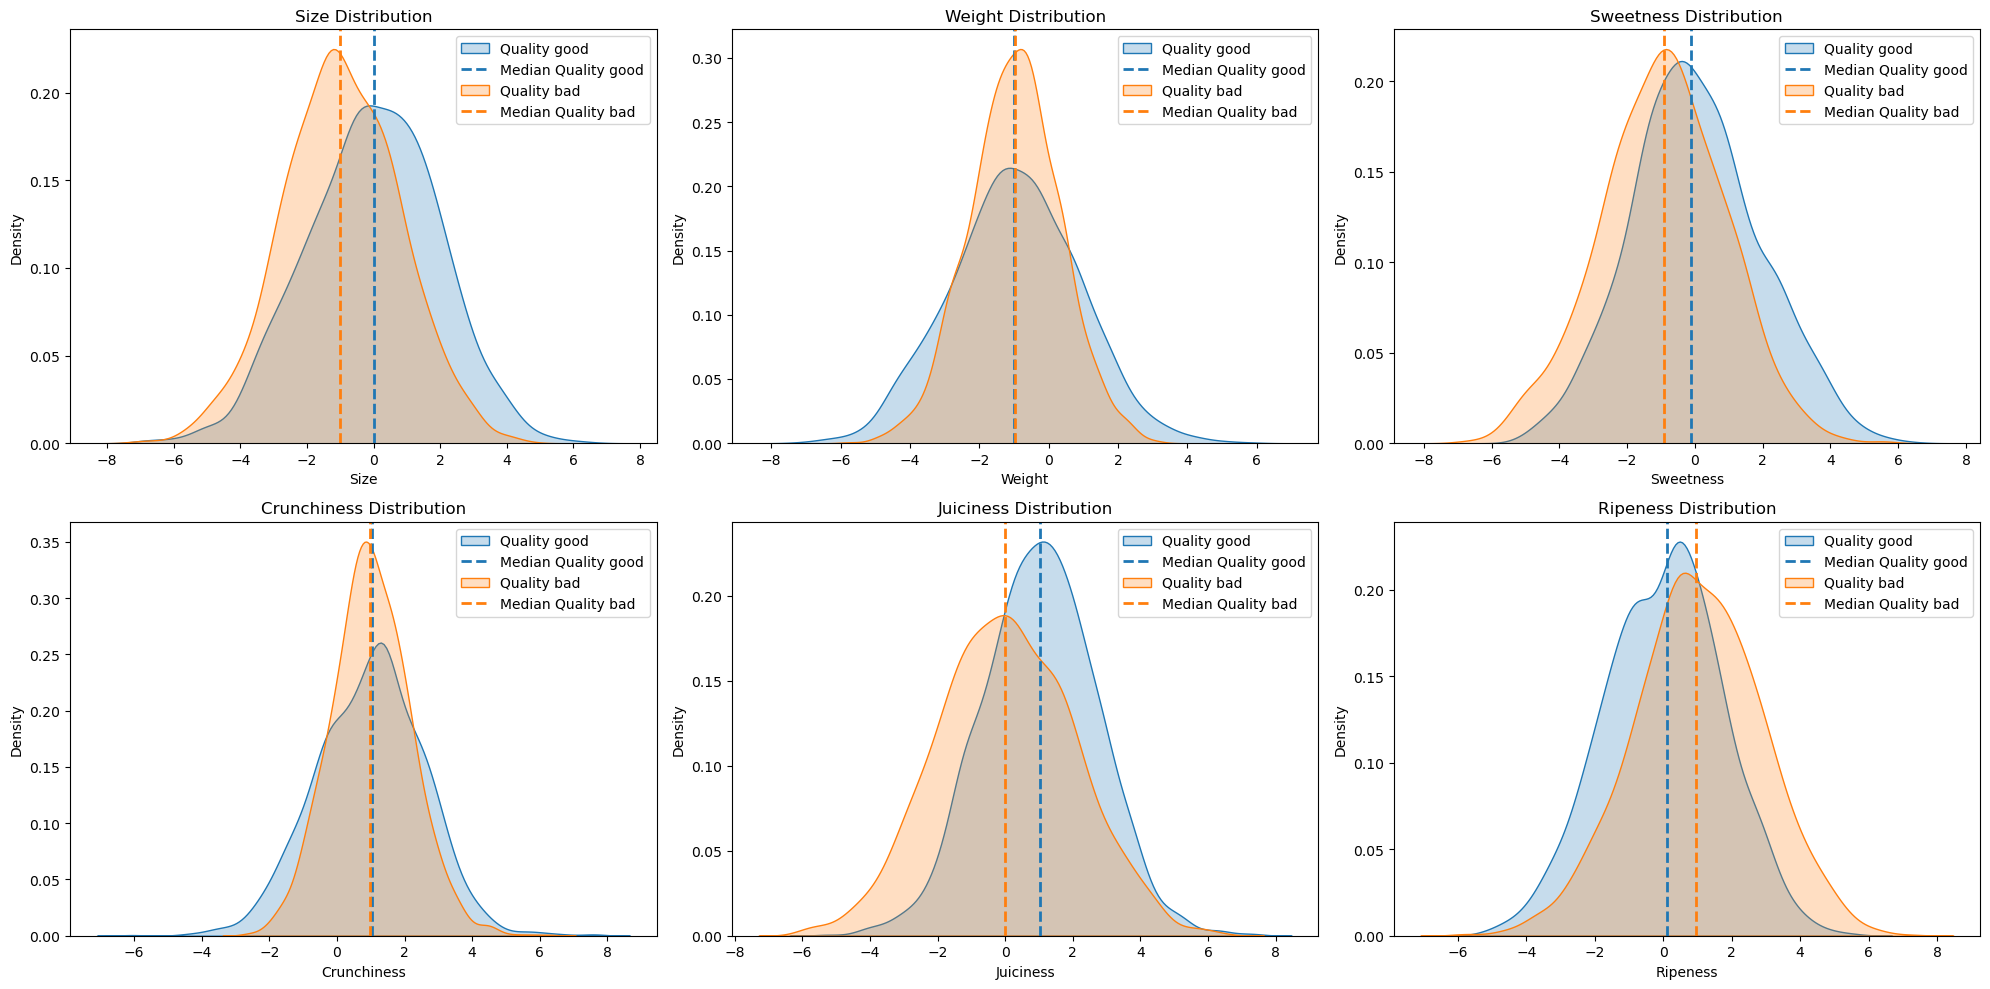

In [27]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(nrows=(len(numeric_columns) + 2) // 3, ncols=3, figsize=(20, 4 * (len(numeric_columns) + 2) // 3))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    for quality_level in df["Quality"].unique():
        subset_data = df[df["Quality"] == quality_level]
        color = sns.color_palette()[list(df["Quality"].unique()).index(quality_level)]
        sns.kdeplot(data=subset_data, x=col, label=f"Quality {quality_level}", fill=True, ax=axes[i], color=color)
        
        middle_value = subset_data[col].median()
        axes[i].axvline(middle_value, linestyle='dashed', linewidth=2, label=f"Median Quality {quality_level}", color=color)

    axes[i].set_title(f"{col} Distribution")
    axes[i].legend()

if len(numeric_columns) % 3 != 0:
    for j in range(len(numeric_columns) % 3, 3):
        fig.delaxes(axes[-j])

plt.tight_layout()
plt.show()

Plot the correlation matrix.

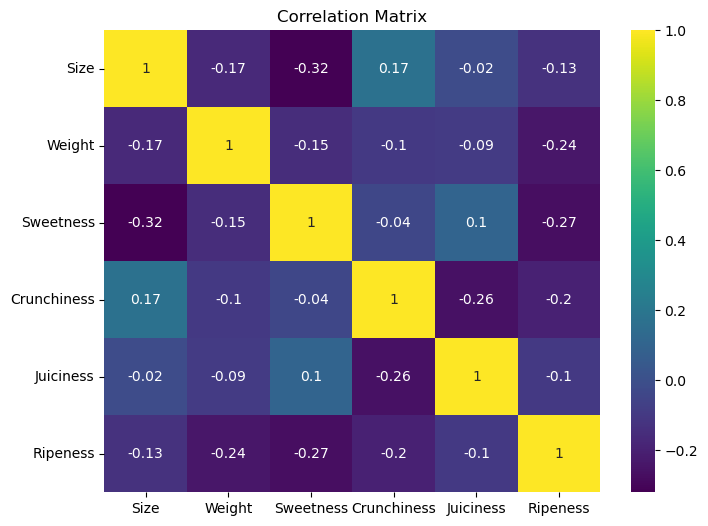

In [28]:
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = np.round(np.corrcoef(numeric_df, rowvar=False), 2)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='viridis', annot=True,
            xticklabels=numeric_df.columns, yticklabels=numeric_df.columns)

plt.title("Correlation Matrix")
plt.show()

# Sec 2: Preprocessing (10 points)

Convert Quality column to a new binary column (having only 0 and 1 values). Then remove the original column.

In [29]:
df['Quality'] = df['Quality'].map({'bad': 0, 'good': 1})

Compute the number of outliners for each feature and remove them.

In [30]:
def find_anomalies(data, column_name):
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    limit = iqr * 1.5
    bot = q1 - limit
    top = q3 + limit
    outliers_count = ((data < (bot)) | (data > (top))).sum()

    result = pd.DataFrame({
        'Column': [column_name],
        'IQR': [iqr],
        'Lower Bound': [bot],
        'Upper Bound': [top],
        'Outliers': [outliers_count]
    })
    return result

df_outliers = pd.DataFrame(columns=['Column', 'IQR', 'Lower Bound', 'Upper Bound', 'Outliers'])

for column in df:
    result = find_anomalies(df[column], column)
    df_outliers = pd.concat([df_outliers, result], ignore_index=True)
    
for i,low,up in zip(df_outliers.Column.unique(),df_outliers["Lower Bound"].unique(),df_outliers["Upper Bound"].unique()):
    df = df[(df[i] >= low) & (df[i] <= up)]

display(df_outliers)
print(f"Numbers of Outliers Removed : {df_outliers['Outliers'].sum()}")

,Column,IQR,Lower Bound,Upper Bound,Outliers
0,Size,2.622291,-5.750201,4.738963,22
1,Weight,2.042747,-5.075890,3.095097,54
2,Sweetness,2.540347,-5.548946,4.612442,32
3,Crunchiness,1.831470,-2.684440,4.641439,47
4,Juiciness,2.637262,-4.757179,5.791870,32
5,Ripeness,2.537889,-4.578510,5.573044,24
6,Quality,1.000000,-1.500000,2.500000,0


Numbers of Outliers Removed : 211


# Sec 3: Training Models (30 points)

Convert the dataset (`x` and `y`) into numpy arrays, and split them into "training" and "testing" parts containing 80% and 20% of the data respectively.

In [31]:
X = df.drop("Quality", axis = 1)
y = df['Quality']
X = np.array(X)
y = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Train both LDA and QDA models on the data using `sklearn`.

In [32]:
sklda = LinearDiscriminantAnalysis()
sklda.fit(x_train, y_train)

LinearDiscriminantAnalysis()

In [33]:
skqda = QuadraticDiscriminantAnalysis()
skqda.fit(x_train, y_train)

QuadraticDiscriminantAnalysis()

Implement LDA and QDA.

Linear Discriminant Analysis:

In [34]:
class LDA:
 """
    Fits it on data, then uses predict to get results.
 """
 
 def __init__(self):
    self.mean_vectors = None
    self.covariance_matrix = None
    self.prior_probabilities = None
    self.classes = None
    self.centroids = None

 def fit(self, X, y):
    """Fit the training data
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Features
    y : array-like, shape = [n_samples, n_labels]
        Labels
    Returns
    -------
    self : object
    """

    n_samples, n_features = X.shape
    self.classes = np.unique(y)
    n_classes = len(self.classes)

    self.mean_vectors = []
    self.covariance_matrix = np.zeros((n_features, n_features))
    self.prior_probabilities = []
    self.centroids = []


    for c in self.classes:
        X_c = X[y == c]
        self.mean_vectors.append(np.mean(X_c, axis=0))
        self.covariance_matrix += (X_c.shape[0] - 1) * np.cov(X_c.T)
        self.prior_probabilities.append(X_c.shape[0] / n_samples)
        self.centroids.append(np.mean(X_c, axis=0))

    self.covariance_matrix /= n_samples - n_classes

    return self

 def predict(self, X):
    """ Predicts the value after the model has been trained.
    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Features
    Returns
    -------
    Predicted value
    """
    n_samples, n_features = X.shape
    predictions = []

    for x in X:
        discriminant_scores = []

        for i in range(len(self.classes)):
            mean_vector = self.mean_vectors[i]
            covariance_matrix = self.covariance_matrix
            prior_probability = self.prior_probabilities[i]

            diff = x - mean_vector
            mahalanobis_distance = np.sqrt(np.dot(np.dot(diff.T, np.linalg.inv(covariance_matrix)), diff))

            discriminant_score = -0.5 * mahalanobis_distance ** 2 + np.log(prior_probability)
            discriminant_scores.append(discriminant_score)

        predicted_class = self.classes[np.argmax(discriminant_scores)]
        predictions.append(predicted_class)

    return np.array(predictions)

Quadratic Discriminant Analysis:

In [35]:
class QDA:
    """
    Fits it on data, then uses predict to get results.
    """

    def __init__(self):
        self.means_ = None
        self.covariance_matrices_ = None
        self.priors_ = None
        self.classes_ = None
    
    def fit(self, X, y):
        """Fit the training data
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Features
        y : array-like, shape = [n_samples, ]
            Labels
        Returns
        -------
        self : object
        """

        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.means_ = np.zeros((n_classes, n_features))
        self.covariance_matrices_ = np.zeros((n_classes, n_features, n_features))
        self.priors_ = np.zeros(n_classes)

        for idx, label in enumerate(self.classes_):
            X_c = X[y == label]
            self.means_[idx, :] = X_c.mean(axis=0)
            self.covariance_matrices_[idx, :, :] = np.cov(X_c.T)
            self.priors_[idx] = X_c.shape[0] / float(n_samples)
        
        return self
    
    def predict(self, X):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Features
        Returns
        -------
        Predicted value
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        scores = np.zeros((n_samples, n_classes))

        for i, (mean, cov, prior) in enumerate(zip(self.means_, self.covariance_matrices_, self.priors_)):
            difference = X - mean
            term1 = np.log(prior)
            term2 = -0.5 * np.log(np.linalg.det(cov))
            term3 = -0.5 * np.sum(difference.dot(np.linalg.inv(cov)) * difference, axis=1)
            scores[:, i] = term1 + term2 + term3

        return self.classes_[np.argmax(scores, axis=1)]


Train your models!

In [36]:
lda = LDA()
lda_model = lda.fit(x_train, y_train)

In [37]:
qda = QDA()
qda_model = qda.fit(x_train, y_train)

# Sec 4: Plotting Voronoi Diagram Using Your Own Models (25 points)

*LDA*: Using the centroids from the transformed space, plot the Voronoi diagram.

*QDA*: Given the complexity of decision boundaries in QDA, plotting a traditional Voronoi diagram might be difficult. Focus on approximating the decision regions or boundaries that separate your classes. Adapt the concept of a Voronoi diagram to visualize these regions.

# Sec 5: Evaluation (10 points)

Using all 4 models, predict the labels for all samples belonging to the "testing" part.

In [38]:
y_pred_sklda = sklda.predict(x_test)
y_pred_skqda = skqda.predict(x_test)
y_pred_lda = lda.predict(x_test)
y_pred_qda = qda.predict(x_test)

Calculate Accuracy, Precision, Recall, and F1-Score for your own models.

In [39]:
print('LDA:')
print(classification_report(y_test, y_pred_lda))

LDA:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       407
           1       0.70      0.74      0.72       355

    accuracy                           0.73       762
   macro avg       0.73      0.73      0.73       762
weighted avg       0.73      0.73      0.73       762


In [40]:
print('QDA:')
print(classification_report(y_test, y_pred_qda))

QDA:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       407
           1       0.79      0.81      0.80       355

    accuracy                           0.81       762
   macro avg       0.81      0.81      0.81       762
weighted avg       0.81      0.81      0.81       762


Compute the ROC AUC Score using `sklearn`. (for both LDA and QDA models trained using this library.)

In [41]:
print('LDA:')
print(roc_auc_score(y_test, y_pred_sklda))

0.7330103470948541


In [42]:
print('QDA:')
print(roc_auc_score(y_test, y_pred_skqda))

0.8134962106793092


# Sec 6: KNN

20 points for implementing KNN.
5 points for loading dataset, splitting it into training and testing parts and reporting the accuracy.
15 points for implementing plotting the decision boundary.
5 points for running decision_boundary_plot function.
5 points for interpreting the results.

Implement KNN and plot the decision boundary.

In [7]:
def knn(training_x, training_y, testing_x, k):
    """
    K-Nearest Neighbors
    
    Parameters
    ----------
    training_x : array-like, shape = [n_samples, n_features]
        Training data
    training_y : array-like, shape = [n_samples, ]
        Training labels
    testing_x : array-like, shape = [n_samples, n_features]
        Testing data
    k : int
        Number of neighbors to use
    """
    
    distances = np.sqrt(np.sum((training_x - testing_x)**2, axis=1))
    sorted_indices = np.argsort(distances)
    k_nearest_indices = sorted_indices[:k]
    k_nearest_labels = training_y[k_nearest_indices]
    prediction = np.bincount(k_nearest_labels).argmax()
    
    return prediction

Test your KNN model on the dataset and report the accuracy.

In [65]:
# load 10000 samples from make_moons dataset and a desired noise level
X, y = make_moons(n_samples=10000, noise=0.1, random_state=42)

# split the dataset into training and testing parts
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [66]:
# Run Knn with k=3 on dataset and report its accuracy (you can use sklearn's accuracy_score)

k = 3
y_pred = np.array([knn(x_train, y_train, x_test[i], k) for i in range(len(x_test))])
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9985


In [67]:
def decision_boundary_plot(x_train, y_train, k):
    """
    Plots the decision boundary for KNN
    
    Parameters
    ----------
    x_train : array-like, shape = [n_samples, n_features]
        Training data
    y_train : array-like, shape = [n_samples, ]
        Training labels
    k : int
        Number of neighbors to use
    """
    
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = np.array([knn(x_train, y_train, np.array([x, y]), k) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.5)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=20, edgecolor='k', linewidths=0.5, cmap='viridis')
    plt.title(f'KNN (k={k}) Decision Boundary')
    plt.show()

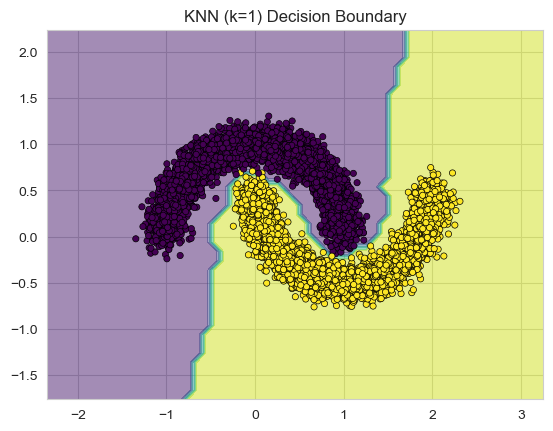

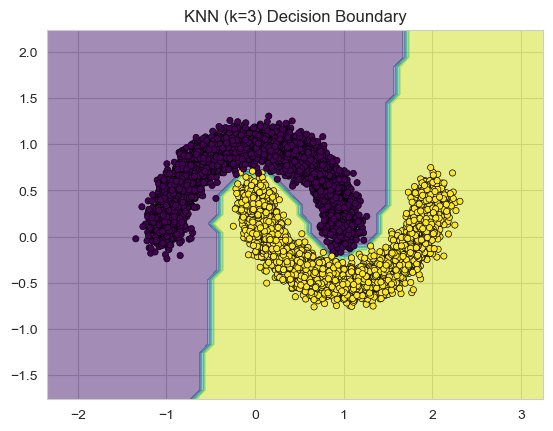

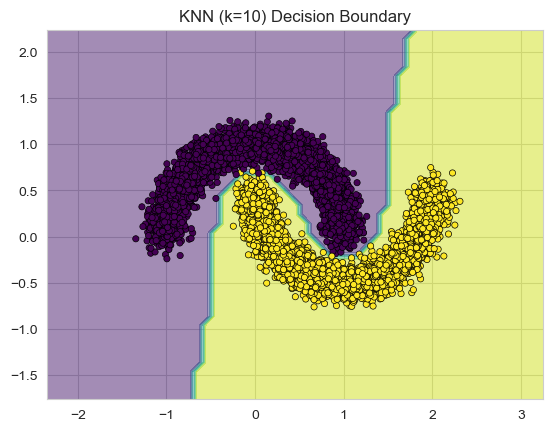

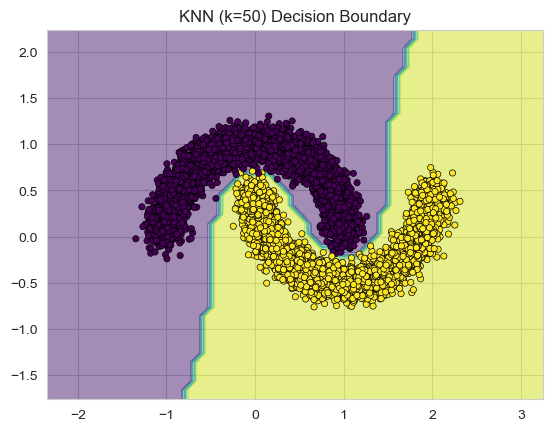

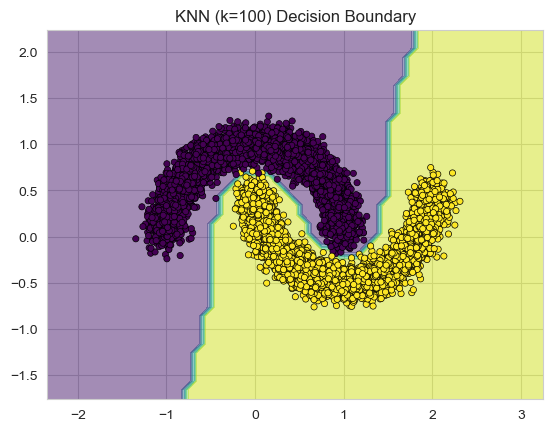

In [68]:
# Plot the decision boundary for KNN with k=[1, 3, 10, 50, 100]
# At the end, interpret the results.

k = [1, 3, 10, 50, 100]
for i in k:
    decision_boundary_plot(x_train, y_train, i)

# Interpret the results:
## Why decision boundaries change in that way?